In [1]:
import os
import mne
from mne import cov
from mne.preprocessing import ICA
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
import pathlib

matplotlib.use('Qt5Agg')

%matplotlib inline

from mne.channels import make_dig_montage

from mne.preprocessing import ICA, create_eog_epochs, create_ecg_epochs,corrmap

In [2]:
data_path = 'C:/Users/pkhan/Desktop/Kaiserslautern/Thesis/Data/p02_4760'
name = 'p02_4760_auditory.fif' 
raw = mne.io.read_raw_fif(os.path.join(data_path, name), preload=True)

print(raw)
print(raw.info)

Opening raw data file C:/Users/pkhan/Desktop/Kaiserslautern/Thesis/Data/p02_4760\p02_4760_auditory.fif...
    Range : 159328 ... 960989 =    159.328 ...   960.989 secs
Ready.


C:\Users\pkhan\AppData\Local\Temp\ipykernel_9472\1116782897.py:3: RuntimeWarning: This filename (C:/Users/pkhan/Desktop/Kaiserslautern/Thesis/Data/p02_4760\p02_4760_auditory.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(os.path.join(data_path, name), preload=True)


Reading 0 ... 801661  =      0.000 ...   801.661 secs...
<Raw | p02_4760_auditory.fif, 191 x 801662 (801.7 s), ~1.14 GB, data loaded>
<Info | 21 non-empty values
 acq_pars: ACQch001 11001 ACQch002 111002 ACQch003 111003 ACQch004 111004 ...
 bads: []
 ch_names: MEG 002, MEG 003, MEG 004, MEG 005, MEG 007, MEG 008, MEG 009, ...
 chs: 119 Gradiometers, 7 Stimulus, 64 EEG, 1 ECG
 custom_ref_applied: True
 description: These data were measured with Neuromag-122
 dev_head_t: MEG device -> head transform
 dig: 150 items (3 Cardinal, 4 HPI, 64 EEG, 79 Extra)
 events: 2 items (list)
 experimenter: eeg
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 330.0 Hz
 meas_date: 2024-10-31 13:12:02 UTC
 meas_id: 4 items (dict)
 nchan: 191
 proj_id: 1 item (ndarray)
 proj_name: andre
 projs: []
 sfreq: 1000.0 Hz
 subject_info: 3 items (dict)
>


In [3]:
raw.plot()

Using qt as 2D backend.


In [4]:
# raw.crop(tmin=50, tmax=None)  # tmin=50 seconds means cutting off first 50 seconds
# raw.save(os.path.join(data_path, 'p02_4760_auditory.fif'), overwrite=True)

In [5]:
# Change EEG064 to ECG
raw.set_channel_types({'EEG 064': 'ecg'})


<Raw | p02_4760_auditory.fif, 191 x 801662 (801.7 s), ~1.14 GB, data loaded>

143 events found on stim channel STI 001
Event IDs: [5]
86 events found on stim channel STI 002
Event IDs: [5]
1 event found on stim channel STI 003
Event IDs: [5]
143 events found on stim channel STI 004
Event IDs: [5]
18 events found on stim channel STI 005
Event IDs: [5]
97 events found on stim channel STI 006
Event IDs: [5]
unique ID's found:  [ 1  2  7  8 16 32 41 42 43]
[[163060      0      8]
 [164133      0      1]
 [165204      0     43]
 [171469      0     16]
 [171533      0      2]
 [172549      0      1]
 [173608      0     41]
 [178970      0      8]
 [180049      0      1]
 [181110      0     42]
 [191104      0      8]
 [192181      0      1]
 [193259      0     43]
 [200075      0     16]
 [200147      0      2]
 [201147      0      1]
 [202267      0     41]
 [208373      0      8]
 [209463      0      1]
 [210565      0     42]
 [221156      0      8]
 [222229      0      1]
 [223299      0     43]
 [233458      0     16]
 [233528      0      2]
 [234528      0      

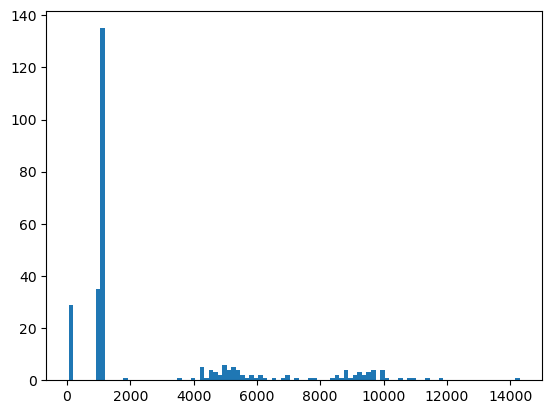

In [6]:
"""Checking trigger lines
17 Sept 2024
"""

from functools import reduce
from itertools import combinations

# %%
def find_6ch_binary_events(raw):
    adjust_timeline_by_msec = 0
    shortest_event = 0.001
    min_duration = 0.003

    # Binary Coding of 6 Stim Channels in Biomagenetism Lab Heidelberg
    # prepare arrays
    events = np.ndarray(shape=(0, 3), dtype=np.int32)
    evs = list()
    evs_tol = list()

    # Find events for each stim channel, append sample values to list
    evs.append(
        mne.find_events(
            raw,
            min_duration=min_duration,
            shortest_event=shortest_event,
            stim_channel=["STI 001"],
        )[:, 0]
    )
    evs.append(
        mne.find_events(
            raw,
            min_duration=min_duration,
            shortest_event=shortest_event,
            stim_channel=["STI 002"],
        )[:, 0]
    )
    evs.append(
        mne.find_events(
            raw,
            min_duration=min_duration,
            shortest_event=shortest_event,
            stim_channel=["STI 003"],
        )[:, 0]
    )
    evs.append(
        mne.find_events(
            raw,
            min_duration=min_duration,
            shortest_event=shortest_event,
            stim_channel=["STI 004"],
        )[:, 0]
    )
    evs.append(
        mne.find_events(
            raw,
            min_duration=min_duration,
            shortest_event=shortest_event,
            stim_channel=["STI 005"],
        )[:, 0]
    )
    evs.append(
        mne.find_events(
            raw,
            min_duration=min_duration,
            shortest_event=shortest_event,
            stim_channel=["STI 006"],
        )[:, 0]
    )

    for i in evs:
        # delete events in each channel,
        # which are too close too each other (1ms)
        too_close = np.where(np.diff(i) <= 1)
        if np.size(too_close) >= 1:
            print(
                f"Two close events (1ms) at samples "
                f"{i[too_close] + raw.first_samp}, first deleted"
            )
            i = np.delete(i, too_close, 0)
            evs[evs.index(i)] = i

        # add tolerance to each value
        i_tol = np.ndarray(shape=(0, 1), dtype=np.int32)
        for t in i:
            i_tol = np.append(i_tol, t - 1)
            i_tol = np.append(i_tol, t)
            i_tol = np.append(i_tol, t + 1)

        evs_tol.append(i_tol)

    # Get events from combinated Stim-Channels
    equals = reduce(
        np.intersect1d,
        (evs_tol[0], evs_tol[1], evs_tol[2], evs_tol[3], evs_tol[4], evs_tol[5]),
    )
    # elimnate duplicated events
    too_close = np.where(np.diff(equals) <= 1)
    if np.size(too_close) >= 1:
        equals = np.delete(equals, too_close, 0)
        equals -= 1  # correction, because of shift with deletion

    for q in equals:
        if (
            q not in events[:, 0]
            and q not in events[:, 0] + 1
            and q not in events[:, 0] - 1
        ):
            events = np.append(events, [[q, 0, 63]], axis=0)

    for a, b, c, d, e in combinations(range(6), 5):
        equals = reduce(
            np.intersect1d, (evs_tol[a], evs_tol[b], evs_tol[c], evs_tol[d], evs_tol[e])
        )
        too_close = np.where(np.diff(equals) <= 1)
        if np.size(too_close) >= 1:
            equals = np.delete(equals, too_close, 0)
            equals -= 1

        for q in equals:
            if (
                q not in events[:, 0]
                and q not in events[:, 0] + 1
                and q not in events[:, 0] - 1
            ):
                events = np.append(
                    events,
                    [[q, 0, int(2**a + 2**b + 2**c + 2**d + 2**e)]],
                    axis=0,
                )

    for a, b, c, d in combinations(range(6), 4):
        equals = reduce(
            np.intersect1d, (evs_tol[a], evs_tol[b], evs_tol[c], evs_tol[d])
        )
        too_close = np.where(np.diff(equals) <= 1)
        if np.size(too_close) >= 1:
            equals = np.delete(equals, too_close, 0)
            equals -= 1

        for q in equals:
            if (
                q not in events[:, 0]
                and q not in events[:, 0] + 1
                and q not in events[:, 0] - 1
            ):
                events = np.append(
                    events, [[q, 0, int(2**a + 2**b + 2**c + 2**d)]], axis=0
                )

    for a, b, c in combinations(range(6), 3):
        equals = reduce(np.intersect1d, (evs_tol[a], evs_tol[b], evs_tol[c]))
        too_close = np.where(np.diff(equals) <= 1)
        if np.size(too_close) >= 1:
            equals = np.delete(equals, too_close, 0)
            equals -= 1

        for q in equals:
            if (
                q not in events[:, 0]
                and q not in events[:, 0] + 1
                and q not in events[:, 0] - 1
            ):
                events = np.append(events, [[q, 0, int(2**a + 2**b + 2**c)]], axis=0)

    for a, b in combinations(range(6), 2):
        equals = np.intersect1d(evs_tol[a], evs_tol[b])
        too_close = np.where(np.diff(equals) <= 1)
        if np.size(too_close) >= 1:
            equals = np.delete(equals, too_close, 0)
            equals -= 1

        for q in equals:
            if (
                q not in events[:, 0]
                and q not in events[:, 0] + 1
                and q not in events[:, 0] - 1
            ):
                events = np.append(events, [[q, 0, int(2**a + 2**b)]], axis=0)

    # Get single-channel events
    for i in range(6):
        for e in evs[i]:
            if (
                e not in events[:, 0]
                and e not in events[:, 0] + 1
                and e not in events[:, 0] - 1
            ):
                events = np.append(events, [[e, 0, 2**i]], axis=0)

    # sort only along samples(column 0)
    events = events[events[:, 0].argsort()]

    # apply latency correction
    events[:, 0] = [
        ts + np.round(adjust_timeline_by_msec * 10**-3 * raw.info["sfreq"])
        for ts in events[:, 0]
    ]

    ids = np.unique(events[:, 2])
    print("unique ID's found: ", ids)
    return events


# %%
events = find_6ch_binary_events(raw)
print(events)
#%%
# compute the time between events
diffT = np.diff(events[:, 0])
#%%
# please plot a histogram of the time differences
import matplotlib.pyplot as plt
plt.hist(diffT, bins=100)
plt.show()


Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).


C:\Users\pkhan\AppData\Local\Temp\ipykernel_9472\4108630121.py:1: UserWarning: Zero value in spectrum for channels MEG 036, MEG 091, Cz
  raw.compute_psd().plot()
C:\Users\pkhan\AppData\Local\Temp\ipykernel_9472\4108630121.py:1: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raw.compute_psd().plot()
C:\Users\pkhan\AppData\Local\Temp\ipykernel_9472\4108630121.py:1: UserWarning: Infinite value in PSD for channel Cz.
These channels might be dead.
  raw.compute_psd().plot()
C:\Users\pkhan\AppData\Local\Temp\ipykernel_9472\4108630121.py:1: UserWarning: Infinite value in PSD for channels MEG 036, MEG 091.
These channels might be dead.
  raw.compute_psd().plot()
c:\Users\pkhan\anaconda3\envs\mne\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


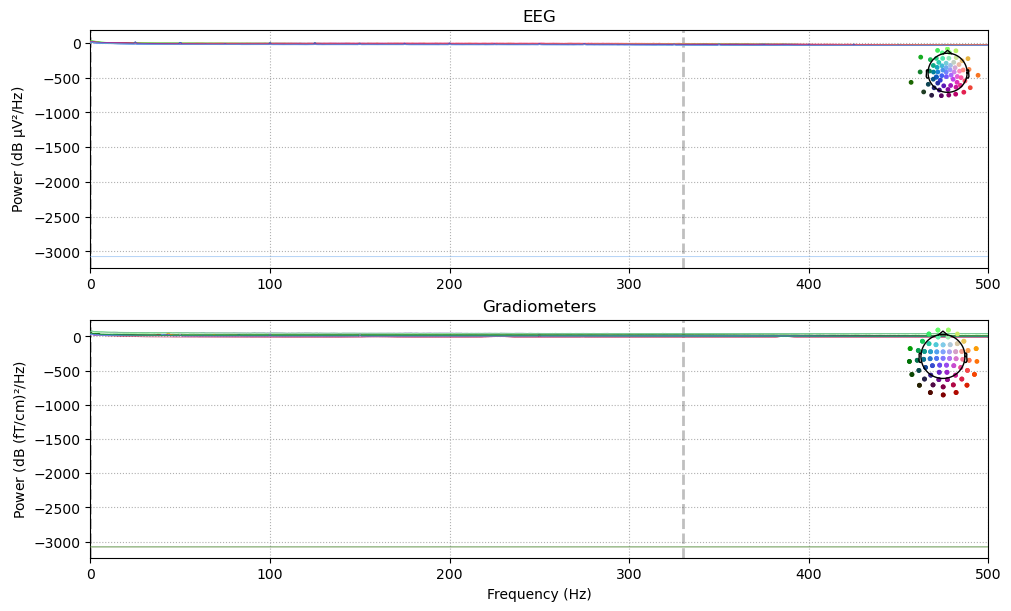

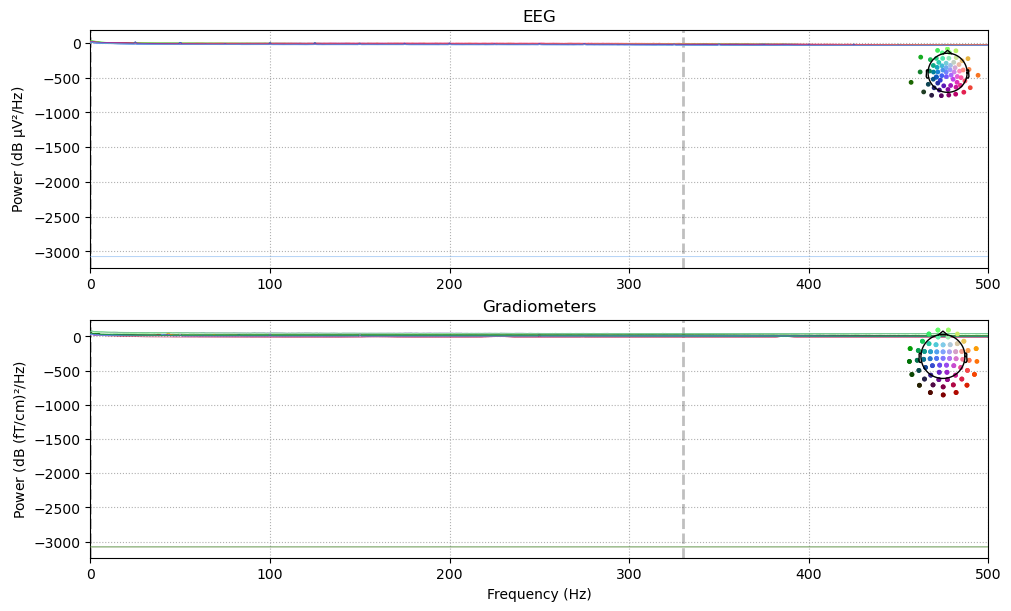

In [7]:
raw.compute_psd().plot()

for p02_xxxx_auditory.fif: Channels marked as bad:
['MEG 007', 'MEG 008', 'MEG 027', 'MEG 036', 'MEG 068', 'MEG 079', 'MEG 091', 'MEG 103']

for p20_xxxx_auditory.fif : Channels marked as bad:
['MEG 006', 'MEG 027', 'MEG 026', 'MEG 068', 'MEG 079', 'MEG 089', 'MEG 091', 'MEG 103']

In [8]:
raw.info['dig'] # to check index of LPA and RPA


[<DigPoint |        LPA : (-74.3, -0.0, 0.0) mm     : head frame>,
 <DigPoint |     Nasion : (0.0, 97.5, -0.0) mm      : head frame>,
 <DigPoint |        RPA : (71.3, 0.0, 0.0) mm       : head frame>,
 <DigPoint |     HPI #1 : (82.5, -16.3, 56.6) mm    : head frame>,
 <DigPoint |     HPI #2 : (35.5, 110.2, 50.3) mm    : head frame>,
 <DigPoint |     HPI #3 : (-75.6, -20.7, 43.4) mm   : head frame>,
 <DigPoint |     HPI #4 : (-41.9, 103.2, 38.2) mm   : head frame>,
 <DigPoint |   Extra #1 : (-7.1, 74.0, 111.7) mm    : head frame>,
 <DigPoint |   Extra #2 : (21.9, 61.6, 120.2) mm    : head frame>,
 <DigPoint |   Extra #3 : (20.4, 32.7, 136.2) mm    : head frame>,
 <DigPoint |   Extra #4 : (-7.7, 15.8, 139.5) mm    : head frame>,
 <DigPoint |   Extra #5 : (-31.0, 30.2, 126.4) mm   : head frame>,
 <DigPoint |   Extra #6 : (-34.8, 57.4, 109.2) mm   : head frame>,
 <DigPoint |   Extra #7 : (9.8, 96.3, 89.0) mm      : head frame>,
 <DigPoint |   Extra #8 : (39.9, 75.5, 95.8) mm     : head fra

Channels marked as bad:
none


In [9]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from mne.channels import make_dig_montage

# --- PARAMETERS ---
channel_no = 63  # number of EEG channels actually digitized (without ECG)
eeg_dig_start = 7
eeg_dig_end = 71  # 64th EEG point (Cz) is at index 70
hpi_dig_start = 3
hpi_coils = 4

# --- GET DIGITIZED POINTS ---
digi = raw.info['dig']

# EEG digitized positions (63 scalp electrodes)
eeg_dig_pos = []
for i in range(eeg_dig_start, eeg_dig_end - 1):  # skip Cz for now
    eeg_dig_pos.append(digi[i]['r'])

# Cz position (64th EEG dig point at index 70)
cz_pos = digi[70]['r']

# HPI coil positions
hpi_pos = []
for j in range(hpi_dig_start, eeg_dig_start):
    hpi_pos.append(digi[j]['r'])

# Head shape points (face and extras)
hsp = []
for k in range(eeg_dig_start, len(digi)):
    hsp.append(digi[k]['r'])

# Get first 63 EEG channel names from raw (skip ECG, STIM, etc.)
eeg_chs = []
for ch_name in raw.info['ch_names']:
    if raw.get_channel_types(picks=ch_name)[0] == 'eeg' and len(eeg_chs) < 63:
        eeg_chs.append(ch_name)

# Map EEG names to positions
eeg_ch_pos = {}
for i in range(63):
    eeg_ch_pos[eeg_chs[i]] = eeg_dig_pos[i]

# Add Cz manually to position map
eeg_ch_pos['Cz'] = cz_pos

# --- ADD Cz TO RAW AS VIRTUAL CHANNEL ---
n_times = raw.n_times
sfreq = raw.info['sfreq']
cz_data = np.zeros((1, n_times))  # shape: (1 channel, n_times)
cz_info = mne.create_info(['Cz'], sfreq=sfreq, ch_types='eeg')
cz_raw = mne.io.RawArray(cz_data, cz_info)
raw.add_channels([cz_raw], force_update_info=True)
print("✅ Cz channel added to raw and montage.")

# --- CREATE MONTAGE ---
montage = make_dig_montage(
    ch_pos=eeg_ch_pos,
    nasion=digi[1]['r'],
    lpa=digi[0]['r'],
    rpa=digi[2]['r'],
    hsp=hsp,
    hpi=hpi_pos
)

# --- APPLY MONTAGE ---
raw.set_montage(montage)

# --- PLOT ---
raw.plot_sensors(ch_type='eeg', show_names=True)

fig = plt.figure(figsize=(10, 5))
ax2d = fig.add_subplot(121)
ax3d = fig.add_subplot(122, projection='3d')
raw.plot_sensors(ch_type='eeg', axes=ax2d)
raw.plot_sensors(ch_type='eeg', axes=ax3d, kind='3d')
ax3d.view_init(azim=70, elev=15)


Creating RawArray with float64 data, n_channels=1, n_times=801662
    Range : 0 ... 801661 =      0.000 ...   801.661 secs
Ready.


ValueError: The following channels are present in more than one input measurement info objects: ['Cz']

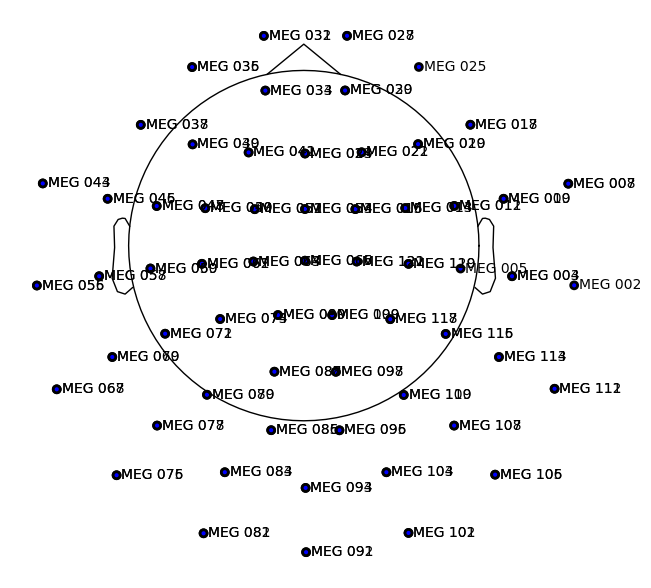

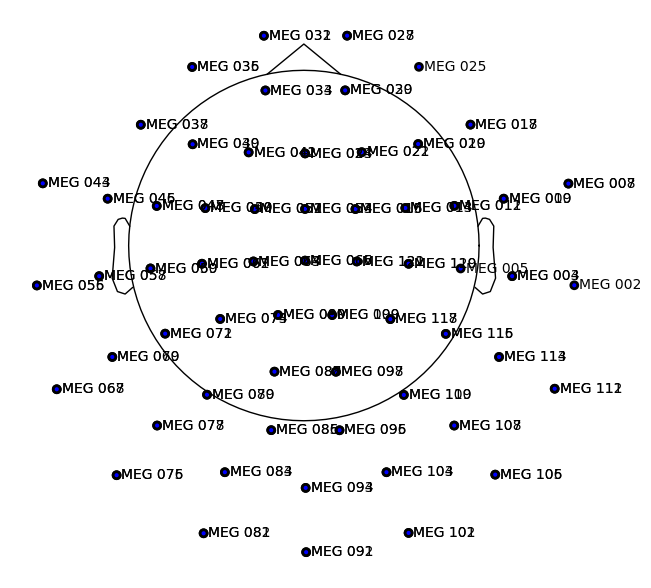

In [10]:
raw.plot_sensors(show_names=True)

In [11]:
raw.info

<Info | 19 non-empty values
 acq_pars: ACQch001 11001 ACQch002 111002 ACQch003 111003 ACQch004 111004 ...
 bads: []
 ch_names: MEG 002, MEG 003, MEG 004, MEG 005, MEG 007, MEG 008, MEG 009, ...
 chs: 119 Gradiometers, 7 Stimulus, 64 EEG, 1 ECG
 custom_ref_applied: False
 description: These data were measured with Neuromag-122
 dev_head_t: MEG device -> head transform
 dig: 150 items (3 Cardinal, 4 HPI, 64 EEG, 79 Extra)
 events: 2 items (list)
 experimenter: eeg
 highpass: 0.0 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 330.0 Hz
 meas_date: 2024-10-31 13:12:02 UTC
 meas_id: 4 items (dict)
 nchan: 191
 proj_id: 1 item (ndarray)
 proj_name: andre
 projs: []
 sfreq: 1000.0 Hz
 subject_info: 3 items (dict)
>

In [12]:
# Set EEG reference to Cz (applies immediately)
raw.set_eeg_reference(ref_channels=['Cz'])

# No need to apply projection
print(raw.info['projs'])  # should be empty or unchanged


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
[]


In [13]:
raw.load_data()
filtered_raw = raw.copy().filter(l_freq=1, h_freq=40)

# # Compute ECG projectors using actual ECG channel
# ecg_projs, ecg_events = mne.preprocessing.compute_proj_ecg(
#     raw,
#     n_grad=1,   # gradiometers
#     n_mag=0,    # no magnetometers
#     n_eeg=1,    # EEG
#     average=True
# )

# # Simulate EOG using a frontal EEG electrode (e.g., 'Fp1')
# eog_projs, eog_events = mne.preprocessing.compute_proj_eog(
#     raw,
#     ch_name='EEG 043',
#     n_grad=1,
#     n_mag=0,
#     n_eeg=1,
#     average=True
# )

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    3.9s


In [12]:
# projs = eog_projs + ecg_projs
# projs

In [13]:
# filtered_raw.plot()

In [14]:
# filtered_raw.plot(events=events)

With the next part of code, I want to split each melodies into its different notes so that each of them become a separtae event:    
    
First melody: 41 (splitted to 411-412-413-414-415-416-417-418) 
        
Second melodies: 42 (splitted to 421-422-423-424-425-426-427-428/431-432-433-434-435-436-437-438)   
    
Third melody: 43 (splitted to 441-442-443-444-445-446-447-448)

In [22]:
# Define parameters
sampling_rate = 1000  # Your EEG/MEG sample rate
note_duration = int(0.450 * sampling_rate)  # 450 ms → 21,600 samples
pause_duration = int(0.800 * sampling_rate)  # 800 ms → 38,400 samples
num_notes = 8  # Each melody consists of 8 notes

# Create a new event list
new_events = []

# Modify the events
for event in events:
    sample, _, event_id = event

    if event_id == 41:  # Melody1 → Replace with 8 notes (411-418)
        for i in range(num_notes):
            new_events.append([sample + i * note_duration, 0, 411 + i])
    
    elif event_id == 42:  # Melody2 → 8 notes (421–428), 800 ms pause, then 8 more notes (441–448)
        first_notes = [[sample + i * note_duration, 0, 421 + i] for i in range(num_notes)]
        last_note_time = first_notes[-1][0]  # Time of last note (428)
        second_notes_start = last_note_time + note_duration + pause_duration  # Start after 800 ms pause
        second_notes = [[second_notes_start + i * note_duration, 0, 431 + i] for i in range(num_notes)]
        new_events.extend(first_notes + second_notes)  # Add both sets of notes
        
    elif event_id == 43:  # Melody3 → Replace with 8 notes (431-438)
        for i in range(num_notes):
            new_events.append([sample + i * note_duration, 0, 441 + i])

    else:
        new_events.append(event.tolist())  # Keep other events unchanged

# Convert back to NumPy and sort by time
new_events = np.array(new_events)
new_events = new_events[new_events[:, 0].argsort()]

# Print confirmation
print("Updated events shape:", new_events.shape)
print(new_events)  # View modified events


Updated events shape: (1174, 3)
[[115595      0      8]
 [115670      0      2]
 [116670      0      1]
 ...
 [953943      0    448]
 [955355      0     16]
 [955427      0      7]]


In [16]:
event_id

7

In [23]:
event_id = {
    "continue": 8,
    "fixation": 2,
    "photodiod": 1,
    "responseC": 16,
    "responseW": 32,
    "note1_melody1": 411,
    "note2_melody1": 412,
    "note3_melody1": 413,
    "note4_melody1": 414,
    "note5_melody1": 415,
    "note6_melody1": 416,
    "note7_melody1": 417,
    "note8_melody1": 418,
    "note1_melody2_part1": 421,
    "note2_melody2_part1": 422,
    "note3_melody2_part1": 423,
    "note4_melody2_part1": 424,
    "note5_melody2_part1": 425,
    "note6_melody2_part1": 426,
    "note7_melody2_part1": 427,
    "note8_melody2_part1": 428,
    "note1_melody2_part2": 431,
    "note2_melody2_part2": 432,
    "note3_melody2_part2": 433,
    "note4_melody2_part2": 434,
    "note5_melody2_part2": 435,
    "note6_melody2_part2": 436,
    "note7_melody2_part2": 437,
    "note8_melody2_part2": 438,
    "note1_melody3": 441,
    "note2_melody3": 442,
    "note3_melody3": 443,
    "note4_melody3": 444,
    "note5_melody3": 445,
    "note6_melody3": 446,
    "note7_melody3": 447,
    "note8_melody3": 448
}

In [25]:
events

array([[115595,      0,      8],
       [115670,      0,      2],
       [116670,      0,      1],
       [117733,      0,     41],
       [122749,      0,      8],
       [123820,      0,      1],
       [124880,      0,     42],
       [136216,      0,      8],
       [137285,      0,      1],
       [138367,      0,     43],
       [143691,      0,     32],
       [143768,      0,      2],
       [144768,      0,      1],
       [145825,      0,     41],
       [151385,      0,      8],
       [152451,      0,      1],
       [153569,      0,     42],
       [163060,      0,      8],
       [164133,      0,      1],
       [165204,      0,     43],
       [171469,      0,     16],
       [171533,      0,      2],
       [172549,      0,      1],
       [173608,      0,     41],
       [178970,      0,      8],
       [180049,      0,      1],
       [181110,      0,     42],
       [191104,      0,      8],
       [192181,      0,      1],
       [193259,      0,     43],
       [20

In [26]:
new_events

array([[115595,      0,      8],
       [115670,      0,      2],
       [116670,      0,      1],
       ...,
       [953943,      0,    448],
       [955355,      0,     16],
       [955427,      0,      7]], dtype=int64)

In [27]:
filtered_raw.plot(events=new_events)

Using qt as 2D backend.


Channels marked as bad:
none


C:\Users\pkhan\AppData\Local\Temp\ipykernel_12732\463825335.py:24: RuntimeWarning: event 4 missing from event_id will be ignored
  fig = mne.viz.plot_events(new_events, raw.info["sfreq"], raw.first_samp, event_id=event_dict)
C:\Users\pkhan\AppData\Local\Temp\ipykernel_12732\463825335.py:24: RuntimeWarning: event 7 missing from event_id will be ignored
  fig = mne.viz.plot_events(new_events, raw.info["sfreq"], raw.first_samp, event_id=event_dict)
C:\Users\pkhan\AppData\Local\Temp\ipykernel_12732\463825335.py:24: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  fig = mne.viz.plot_events(new_events, raw.info["sfreq"], raw.first_samp, event_id=event_dict)


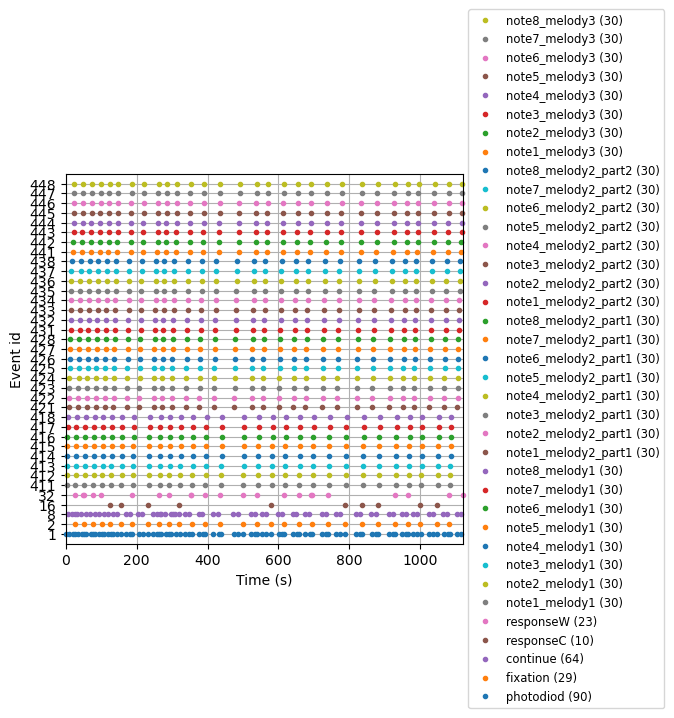

In [19]:
# This is a dictionary to define the meaning of each event code
event_dict = {  
    "continue": 8,
    "fixation": 2,
    "photodiod": 1,
    "responseC": 16,
    "responseW": 32,
}

# Add individual notes for melody1 (411-418)
for i in range(8):
    event_dict[f"note{i+1}_melody1"] = 411 + i  # 411, 412, ..., 418

# Add individual notes for melody2 (421-428 and 441-448)
for i in range(8):
    event_dict[f"note{i+1}_melody2_part1"] = 421 + i  # First 8 notes (421–428)
    event_dict[f"note{i+1}_melody2_part2"] = 431 + i  # Second 8 notes after 800ms pause (441–448)

# Add individual notes for melody3 (431-438)
for i in range(8):
    event_dict[f"note{i+1}_melody3"] = 441 + i  # 431, 432, ..., 438

# Plot updated events
fig = mne.viz.plot_events(new_events, raw.info["sfreq"], raw.first_samp, event_id=event_dict)


In [20]:
event_dict

{'continue': 8,
 'fixation': 2,
 'photodiod': 1,
 'responseC': 16,
 'responseW': 32,
 'note1_melody1': 411,
 'note2_melody1': 412,
 'note3_melody1': 413,
 'note4_melody1': 414,
 'note5_melody1': 415,
 'note6_melody1': 416,
 'note7_melody1': 417,
 'note8_melody1': 418,
 'note1_melody2_part1': 421,
 'note1_melody2_part2': 431,
 'note2_melody2_part1': 422,
 'note2_melody2_part2': 432,
 'note3_melody2_part1': 423,
 'note3_melody2_part2': 433,
 'note4_melody2_part1': 424,
 'note4_melody2_part2': 434,
 'note5_melody2_part1': 425,
 'note5_melody2_part2': 435,
 'note6_melody2_part1': 426,
 'note6_melody2_part2': 436,
 'note7_melody2_part1': 427,
 'note7_melody2_part2': 437,
 'note8_melody2_part1': 428,
 'note8_melody2_part2': 438,
 'note1_melody3': 441,
 'note2_melody3': 442,
 'note3_melody3': 443,
 'note4_melody3': 444,
 'note5_melody3': 445,
 'note6_melody3': 446,
 'note7_melody3': 447,
 'note8_melody3': 448}

In [21]:
# Define the channels based on each fif file

filtered_raw.info['bads'] = ['MEG 001', 'MEG 006', 'MEG 077', 'MEG 078', 'MEG 079', 'MEG 091', 'MEG 027', 'MEG 068', 'MEG 103']

In [24]:
filtered_raw.plot(events=new_events, event_id=event_dict)


In [25]:
# filtered_raw.plot(
#     events=new_events,
#     start=0,
#     event_color={8: "red", 2: "brown", 1: "blue", 411: "gray", 412: "gray", 413: "gray", 414: "gray", 415: "gray", 416: "gray", 417: "gray", 418: "gray", 421: "purple", 422: "purple", 423: "purple", 424: "purple", 425: "purple", 426: "purple", 427: "purple", 428: "purple", 441: "pink", 442: "pink", 443: "pink", 444: "pink", 445: "pink", 446: "pink", 447: "pink", 448: "pink",  431: "green", 432: "green", 433: "green", 434: "green", 435: "green", 436: "green", 437: "green", 438: "green", 16: "orange", 32: "yellow", 7: "black"}
# )


In [22]:
# all_auditory_notes = list(range(411, 419)) + list(range(421, 429)) + list(range(431, 439)) + list(range(441, 449))

auditory_distraction_set = list(range(421, 429)) + list(range(431, 439))  # Melody 2 both parts

auditory_compare_set = list(range(411, 419)) + list(range(441, 449))  # Melody 1 + Melody 4


In [23]:
tmin, tmax = -0.1, 0.5  # 100ms pre-stimulus to 500ms post

# Create dictionaries for event_id mapping (needed for Epochs)
event_id_distraction = {f'note{i}_distraction': code for i, code in enumerate(auditory_distraction_set, 1)}
event_id_comparison = {f'note{i}_compare': code for i, code in enumerate(auditory_compare_set, 1)}

# Extract epochs
epochs_distraction = mne.Epochs(filtered_raw, 
                                new_events, 
                                event_id=event_id_distraction, 
                                tmin=tmin,
                                tmax=tmax, 
                                baseline=(None, 0), 
                                preload=True)

epochs_comparison = mne.Epochs(filtered_raw, 
                               new_events, 
                               event_id=event_id_comparison, 
                               tmin=tmin, 
                               tmax=tmax, 
                               baseline=(None, 0), 
                               preload=True)


Not setting metadata
480 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 480 events and 601 original time points ...
0 bad epochs dropped
Not setting metadata
480 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 480 events and 601 original time points ...
0 bad epochs dropped


Not setting metadata
480 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
480 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"
combining channels using "mean"


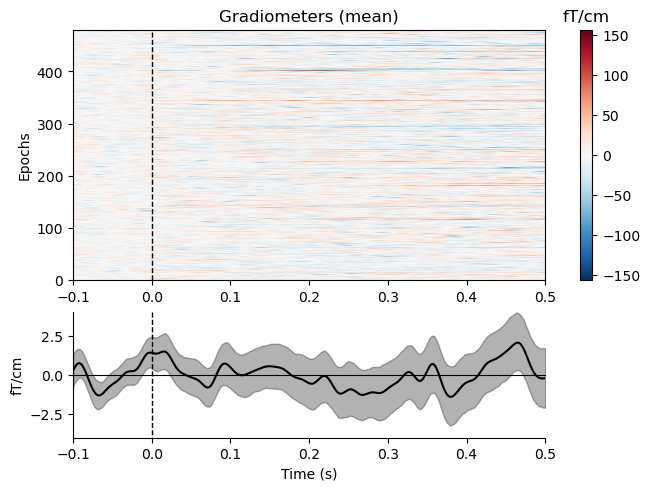

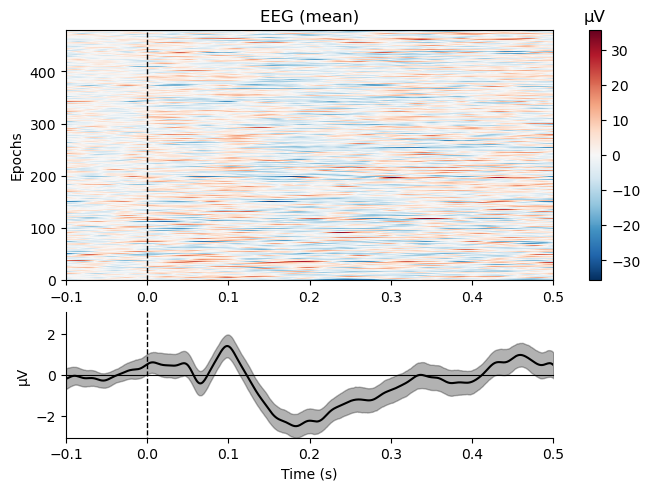

Not setting metadata
480 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
480 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"
combining channels using "mean"


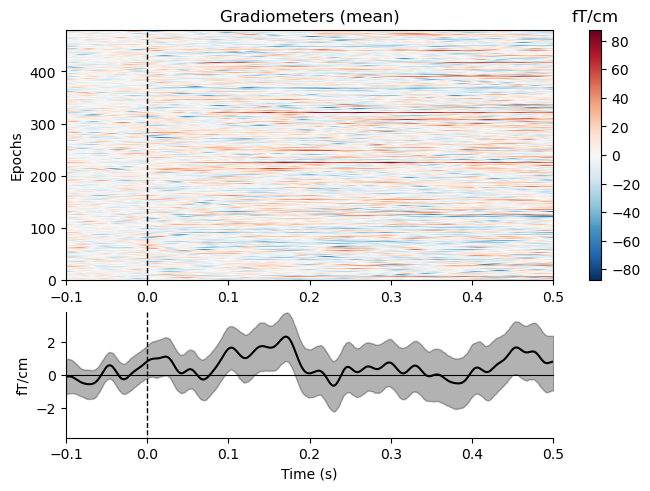

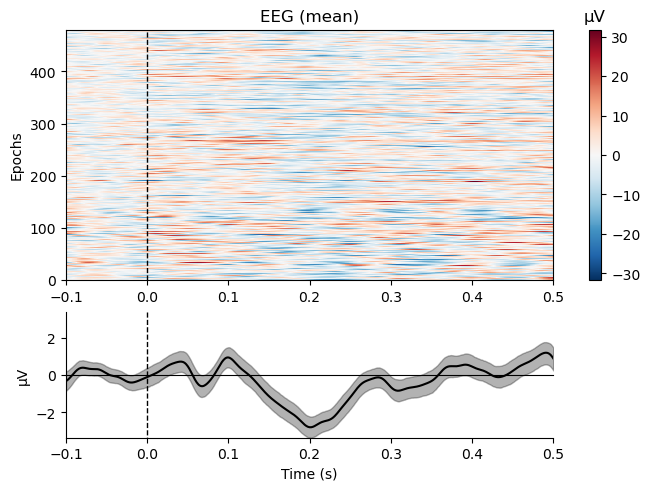

[<Figure size 640x480 with 3 Axes>, <Figure size 640x480 with 3 Axes>]

In [24]:
#plot epochs
epochs_comparison.plot_image(combine='mean')
epochs_distraction.plot_image(combine='mean')

In [25]:
# Drop bad channels from epochs
epochs_comparison.drop_channels(epochs_comparison.info['bads'])
epochs_distraction.drop_channels(epochs_distraction.info['bads'])


<Epochs |  480 events (all good), -0.1 – 0.5 s, baseline -0.1 – 0 s, ~407.5 MB, data loaded,
 'note1_distraction': 30
 'note2_distraction': 30
 'note3_distraction': 30
 'note4_distraction': 30
 'note5_distraction': 30
 'note6_distraction': 30
 'note7_distraction': 30
 'note8_distraction': 30
 'note9_distraction': 30
 'note10_distraction': 30
 and 6 more events ...>

In [26]:
# ICA (Independent Component Analysis) to remove artifacts
# Set parameters for ICA

n_components = 0.95  # Set to 0.95 to retain 95% of variance
method = 'picard'  
max_iter = 800  # Maximum number of iterations for ICA
fit_params = dict(fastica_it=5)
random_state = 42
ica_eeg = mne.preprocessing.ICA(n_components=n_components,
                            method=method,
                            max_iter=max_iter,
                            fit_params=fit_params,
                            random_state=random_state)

ica_meg = mne.preprocessing.ICA(n_components=n_components,
                            method=method,
                            max_iter=max_iter,
                            fit_params=fit_params,
                            random_state=random_state)

from mne import concatenate_epochs

# Fit ICA on the concatenated epochs
# Combine both epoch sets
all_epochs = concatenate_epochs([epochs_comparison, epochs_distraction])
# Fit ICA on the combined epochs
ica_eeg.fit(all_epochs, picks='eeg', decim=3, reject_by_annotation=True)
ica_meg.fit(all_epochs, picks='meg', decim=3, reject_by_annotation=True)

Not setting metadata
960 matching events found
Applying baseline correction (mode: mean)
Fitting ICA to data using 64 channels (please be patient, this may take a while)


C:\Users\pkhan\AppData\Local\Temp\ipykernel_12732\3982474899.py:27: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica_eeg.fit(all_epochs, picks='eeg', decim=3, reject_by_annotation=True)


Selecting by explained variance: 9 components
Fitting ICA took 4.3s.
Fitting ICA to data using 113 channels (please be patient, this may take a while)


C:\Users\pkhan\AppData\Local\Temp\ipykernel_12732\3982474899.py:28: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica_meg.fit(all_epochs, picks='meg', decim=3, reject_by_annotation=True)


Selecting by explained variance: 73 components
Fitting ICA took 298.3s.


<ICA | epochs decomposition, method: picard (fit in 337 iterations on 192960 samples), 73 ICA components (113 PCA components available), channel types: grad, no sources marked for exclusion>

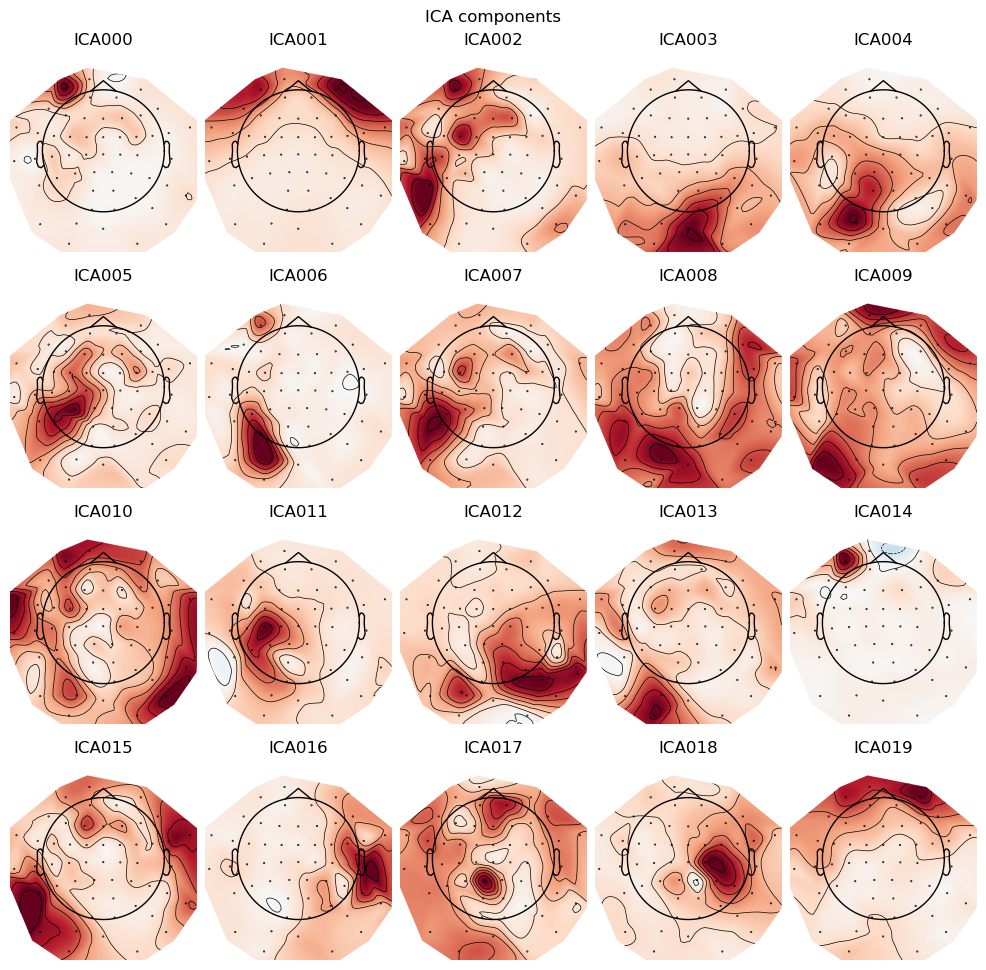

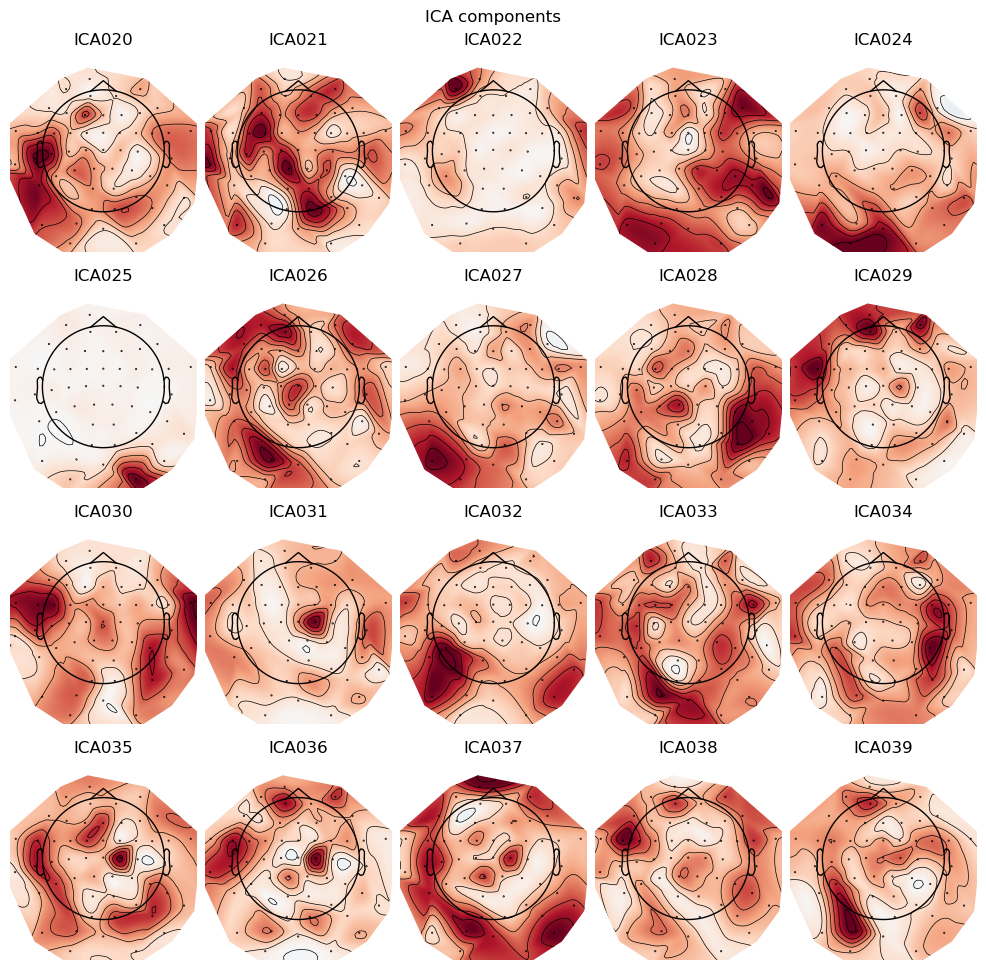

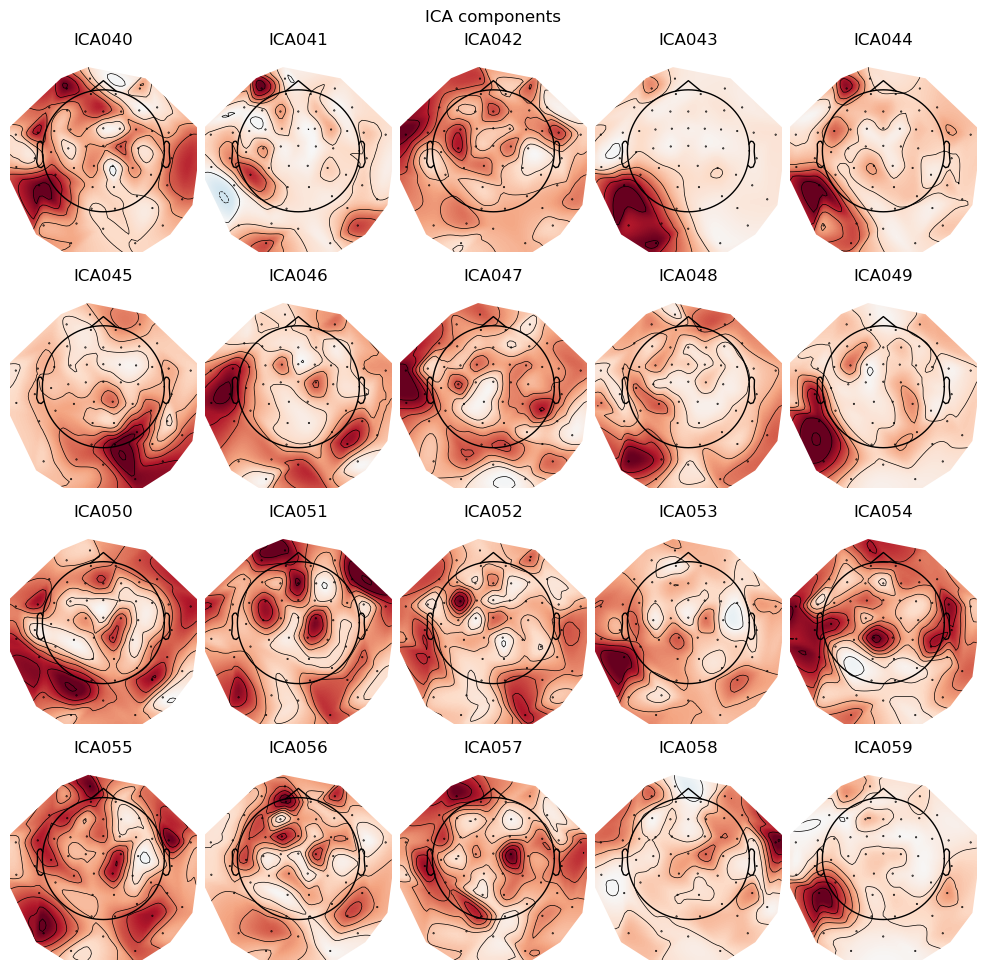

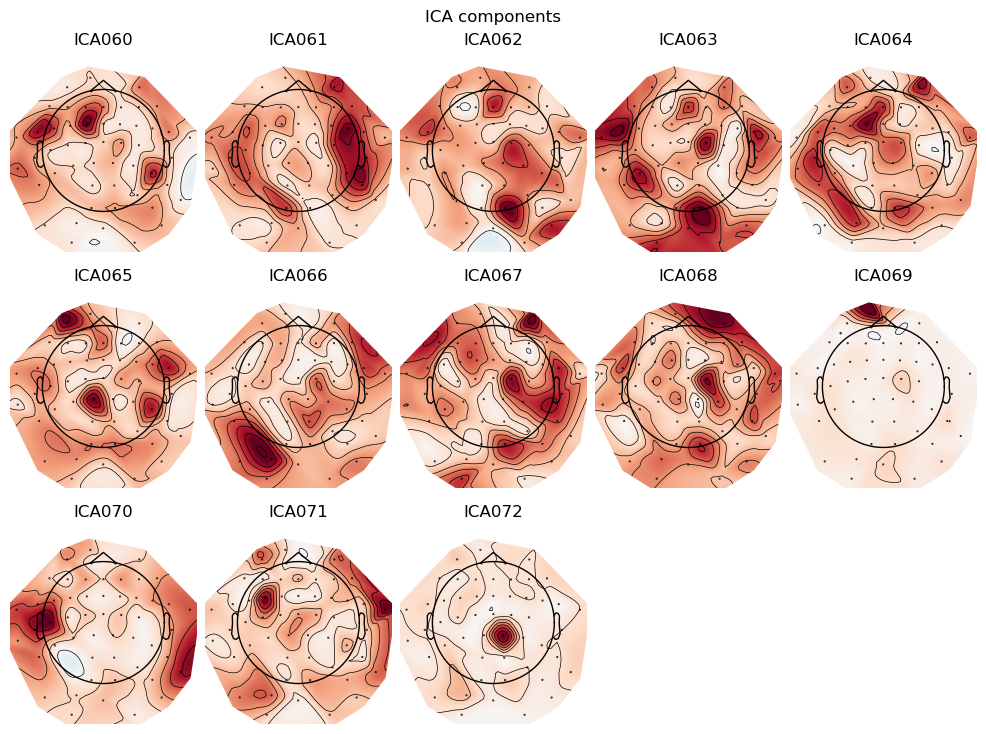

Creating RawArray with float64 data, n_channels=74, n_times=1126125
    Range : 141570 ... 1267694 =    141.570 ...  1267.694 secs
Ready.


In [27]:
ica_meg.plot_components()
ica_meg.plot_sources(filtered_raw)

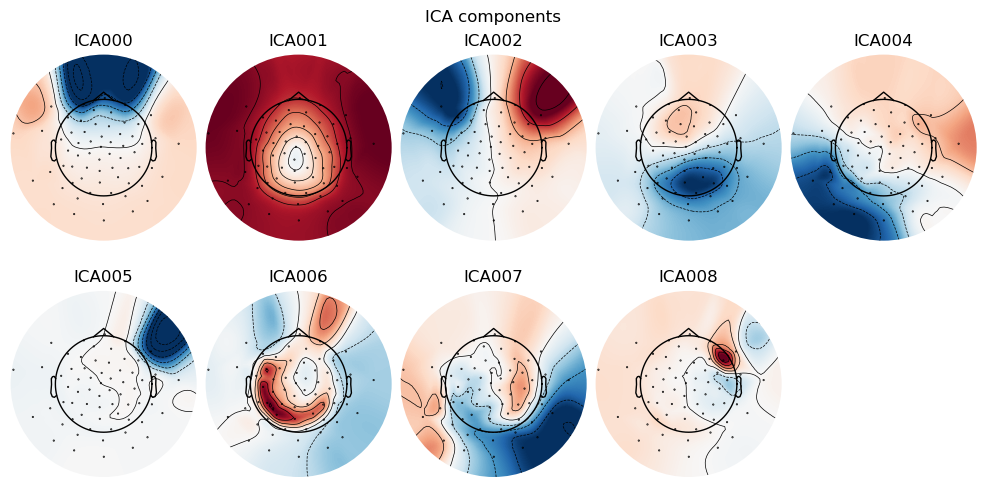

Creating RawArray with float64 data, n_channels=10, n_times=1126125
    Range : 141570 ... 1267694 =    141.570 ...  1267.694 secs
Ready.


In [28]:
ica_eeg.plot_components()

ica_eeg.plot_sources(filtered_raw)

In [29]:
# Create ECG epochs using the ECG channel

ecg_epochs = mne.preprocessing.create_ecg_epochs(filtered_raw, reject=None,
                                                 baseline=(None, -0.2),
                                                 tmin=-0.5, tmax=0.5)
ecg_evoked = ecg_epochs.average()
ecg_inds_eeg, ecg_scores_eeg = ica_eeg.find_bads_ecg(
    ecg_epochs, method='ctps')
ecg_inds_meg, ecg_scores_meg = ica_meg.find_bads_ecg(
    ecg_epochs, method='ctps')


Using channel EEG 064 to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 10000 samples (10.000 s)

Number of ECG events detected : 1312 (average pulse 69 / min.)
Not setting metadata
1312 matching events found
Setting baseline interval to [-0.5, -0.2] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 1312 events and 1001 original time points ...
0 bad epochs dropped
Using threshold: 0.16 for CTPS ECG detection
Using threshold: 0.16 for CTPS ECG detection


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
No projector specified for this dataset. Please consider the method self.add_proj.


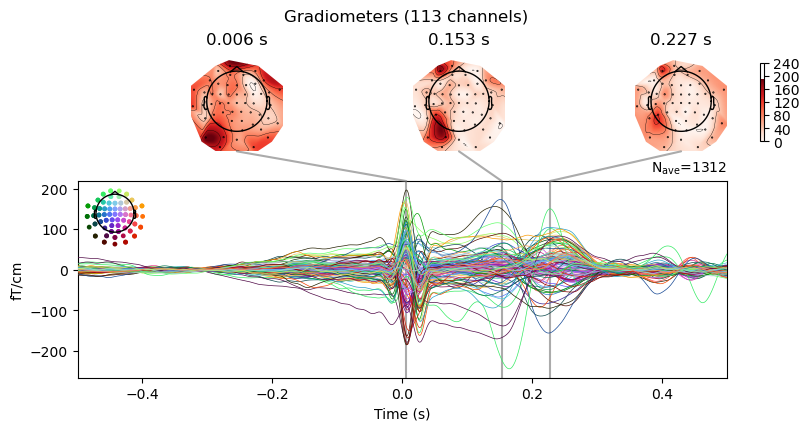

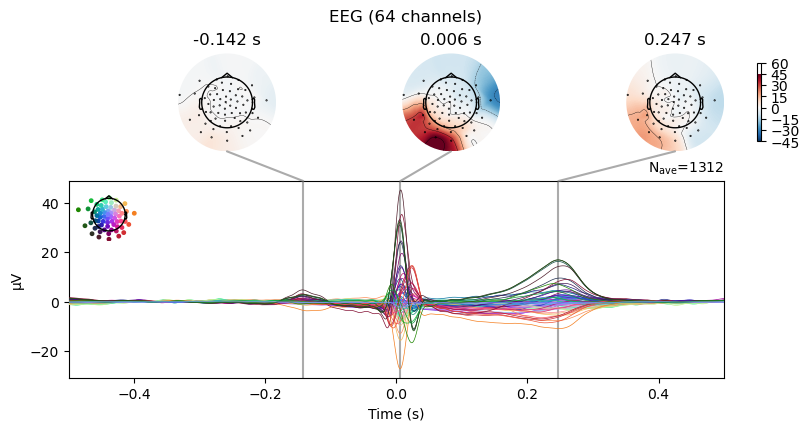

[<Figure size 800x420 with 6 Axes>, <Figure size 800x420 with 6 Axes>]

In [30]:
ecg_evoked.pick_types(meg=True, eeg=True).plot_joint()


In [31]:
# Create EOG epochs using an EEG electrode near the eyes

eog_epochs = create_eog_epochs(filtered_raw, ch_name='EEG 043', reject=None,
                               baseline=(None, -0.2), tmin=-0.5, tmax=0.5)
eog_evoked = eog_epochs.average()
eog_inds_eeg, eog_scores_eeg = ica_eeg.find_bads_eog(filtered_raw, ch_name='EEG 043')
eog_inds_meg, eog_scores_meg = ica_meg.find_bads_eog(filtered_raw, ch_name='EEG 043')

Using EOG channel: EEG 043
EOG channel index for this subject is: [171]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EEG 043 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 226 significant peaks
Number of EOG events detected: 226
Not setting metadata
226 matching events found
Setting baseline interval to [-0.5, -0.2] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 226 events and 1001 original 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    7.2s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)



NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
No projector specified for this dataset. Please consider the method self.add_proj.


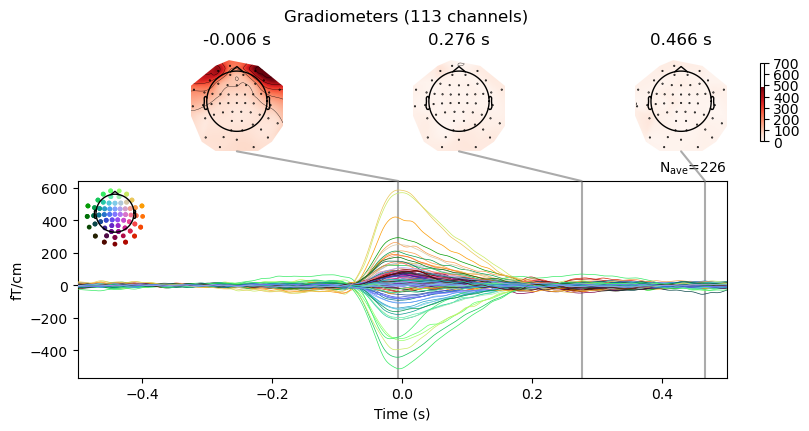

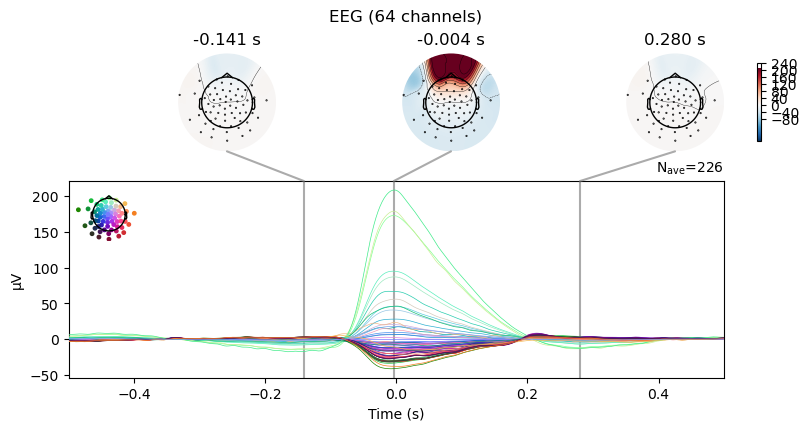

[<Figure size 800x420 with 6 Axes>, <Figure size 800x420 with 6 Axes>]

In [32]:
eog_evoked.pick_types(meg=True, eeg=True).plot_joint()

In [34]:
print("ECG-related components:", ecg_inds_meg)
print("EOG-related components:", eog_inds_meg)

ECG-related components: [9, 10, 6, 15]
EOG-related components: [1]


In [35]:
print("ECG-related components:", ecg_inds_eeg)
print("EOG-related components:", eog_inds_eeg)

ECG-related components: [4, 7, 5, 2]
EOG-related components: []


In [36]:
# add the ECG and EOG components to the exclusion list

ica_eeg.exclude= [0, 1, 4, 7]

In [37]:
# Exclude the components from the ICA

ica_meg.exclude= [1, 6, 9, 10, 14, 15, 19, 25]

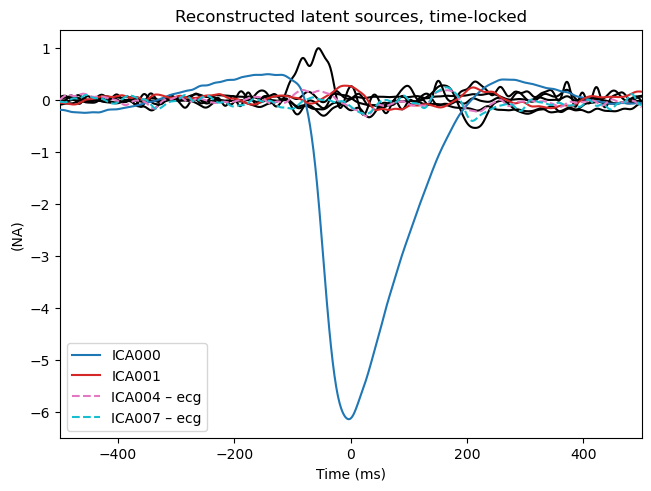

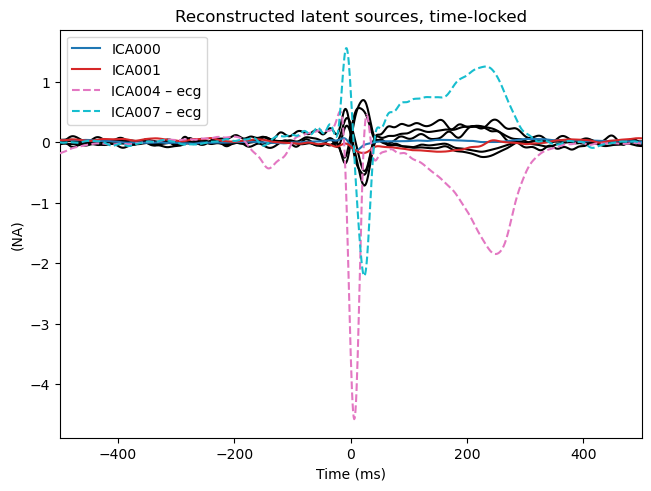

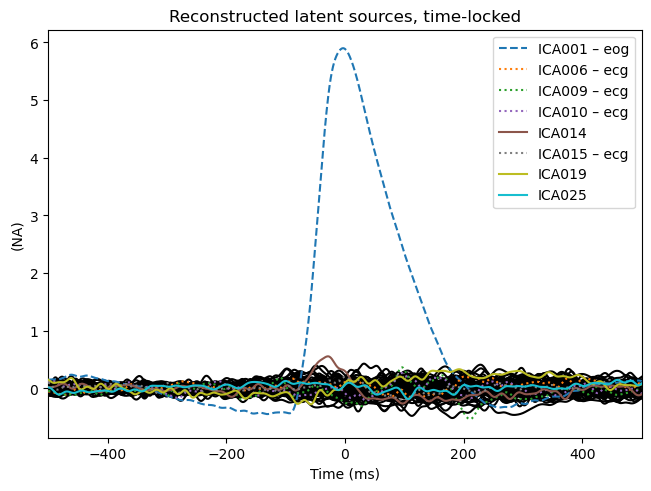

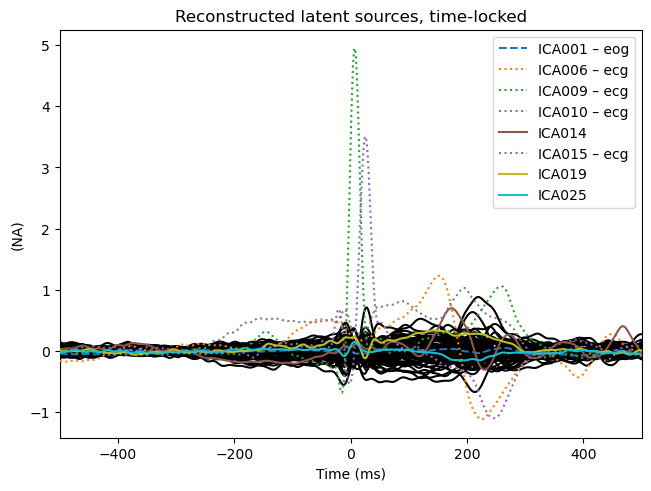

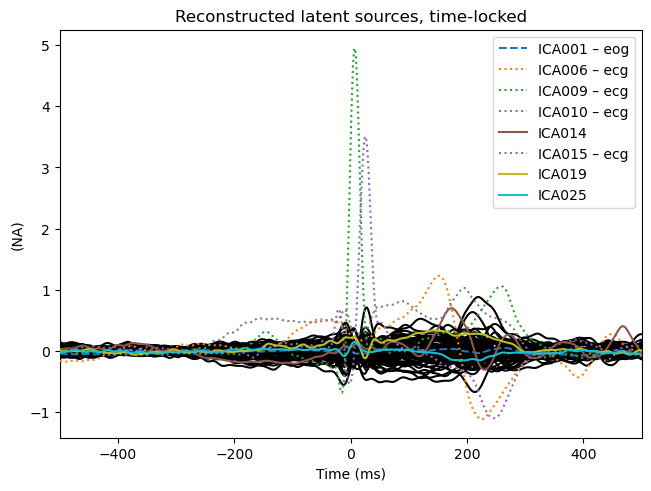

In [38]:
# Plotting the EOG and ECG epochs to visualize the artifacts

ica_eeg.plot_sources(eog_evoked)
ica_eeg.plot_sources(ecg_evoked)

ica_meg.plot_sources(eog_evoked)
ica_meg.plot_sources(ecg_evoked)


Applying ICA to Evoked instance
    Transforming to ICA space (9 components)
    Zeroing out 4 ICA components
    Projecting back using 64 PCA components


C:\Users\pkhan\AppData\Local\Temp\ipykernel_12732\2473538294.py:3: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica_eeg.plot_overlay(ecg_evoked)


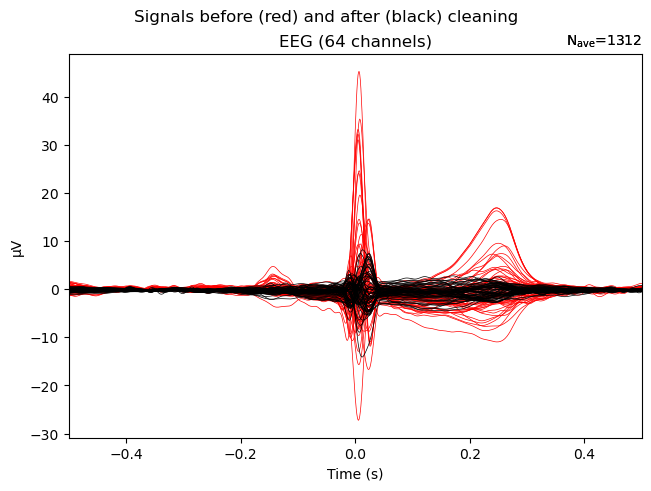

Applying ICA to Evoked instance
    Transforming to ICA space (9 components)
    Zeroing out 4 ICA components
    Projecting back using 64 PCA components


C:\Users\pkhan\AppData\Local\Temp\ipykernel_12732\2473538294.py:4: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica_eeg.plot_overlay(eog_evoked)


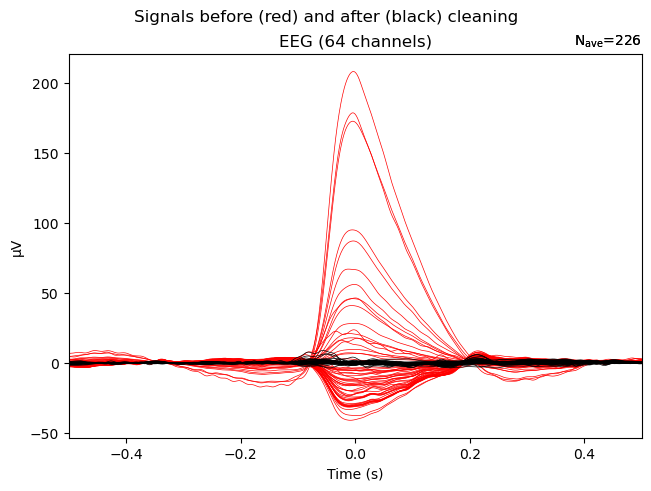

Applying ICA to Evoked instance
    Transforming to ICA space (73 components)
    Zeroing out 8 ICA components
    Projecting back using 113 PCA components


C:\Users\pkhan\AppData\Local\Temp\ipykernel_12732\2473538294.py:6: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica_meg.plot_overlay(ecg_evoked)


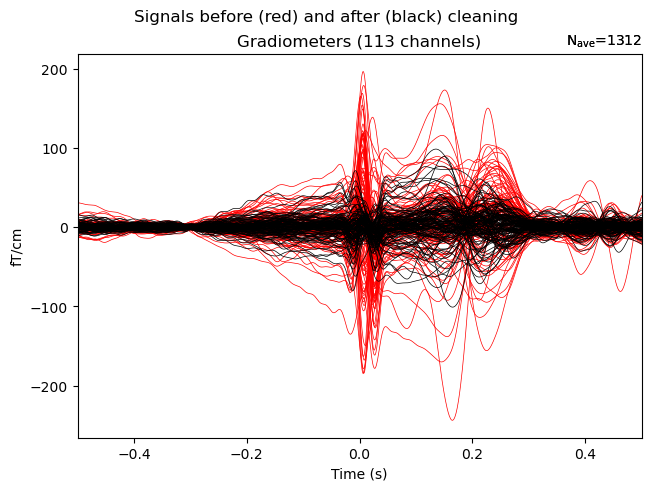

Applying ICA to Evoked instance
    Transforming to ICA space (73 components)
    Zeroing out 8 ICA components
    Projecting back using 113 PCA components


C:\Users\pkhan\AppData\Local\Temp\ipykernel_12732\2473538294.py:7: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica_meg.plot_overlay(eog_evoked)


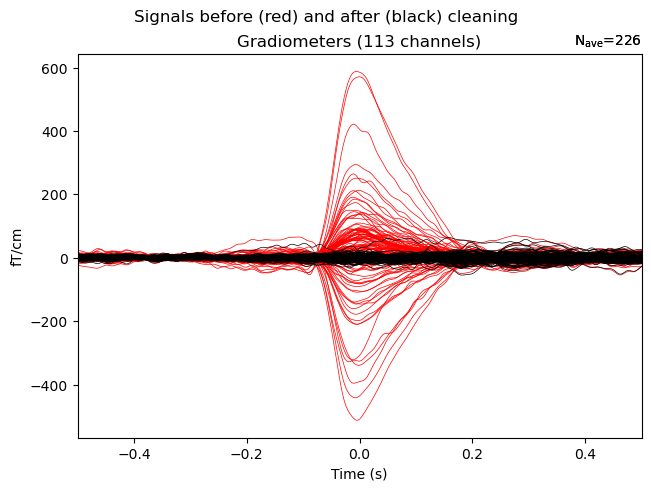

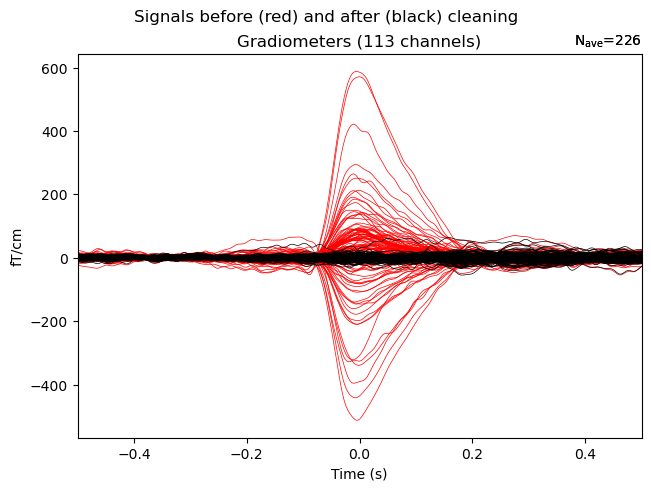

In [39]:
# Showing the ICA components with the ECG and EOG epochs overlaid

ica_eeg.plot_overlay(ecg_evoked)
ica_eeg.plot_overlay(eog_evoked)

ica_meg.plot_overlay(ecg_evoked)
ica_meg.plot_overlay(eog_evoked)


In [40]:
# Copy original epochs to clean both EEG and MEG
clean_epochs_comparison = epochs_comparison.copy()
clean_epochs_distraction = epochs_distraction.copy()

# Apply EEG ICA to remove EEG artifacts
clean_epochs_comparison = ica_eeg.apply(clean_epochs_comparison)
clean_epochs_distraction = ica_eeg.apply(clean_epochs_distraction)

# Then apply MEG ICA to remove MEG artifacts
clean_epochs_comparison = ica_meg.apply(clean_epochs_comparison)
clean_epochs_distraction = ica_meg.apply(clean_epochs_distraction)


Applying ICA to Epochs instance
    Transforming to ICA space (9 components)
    Zeroing out 4 ICA components
    Projecting back using 64 PCA components


C:\Users\pkhan\AppData\Local\Temp\ipykernel_12732\3319775957.py:6: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  clean_epochs_comparison = ica_eeg.apply(clean_epochs_comparison)


Applying ICA to Epochs instance
    Transforming to ICA space (9 components)
    Zeroing out 4 ICA components
    Projecting back using 64 PCA components


C:\Users\pkhan\AppData\Local\Temp\ipykernel_12732\3319775957.py:7: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  clean_epochs_distraction = ica_eeg.apply(clean_epochs_distraction)


Applying ICA to Epochs instance
    Transforming to ICA space (73 components)
    Zeroing out 8 ICA components


C:\Users\pkhan\AppData\Local\Temp\ipykernel_12732\3319775957.py:10: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  clean_epochs_comparison = ica_meg.apply(clean_epochs_comparison)


    Projecting back using 113 PCA components
Applying ICA to Epochs instance
    Transforming to ICA space (73 components)


C:\Users\pkhan\AppData\Local\Temp\ipykernel_12732\3319775957.py:11: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  clean_epochs_distraction = ica_meg.apply(clean_epochs_distraction)


    Zeroing out 8 ICA components
    Projecting back using 113 PCA components


No projector specified for this dataset. Please consider the method self.add_proj.


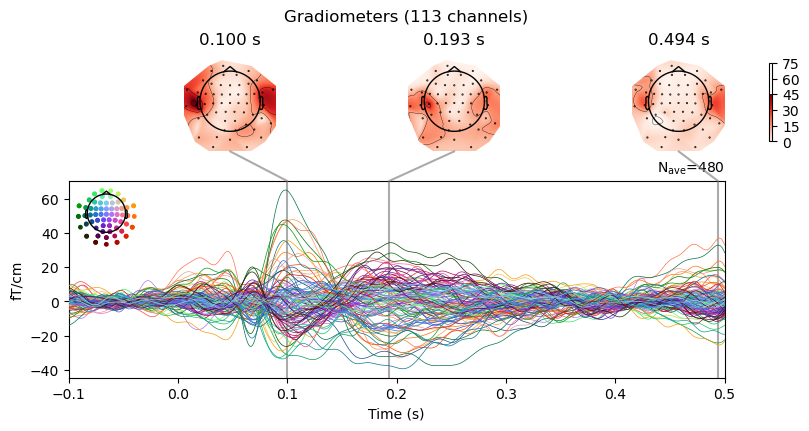

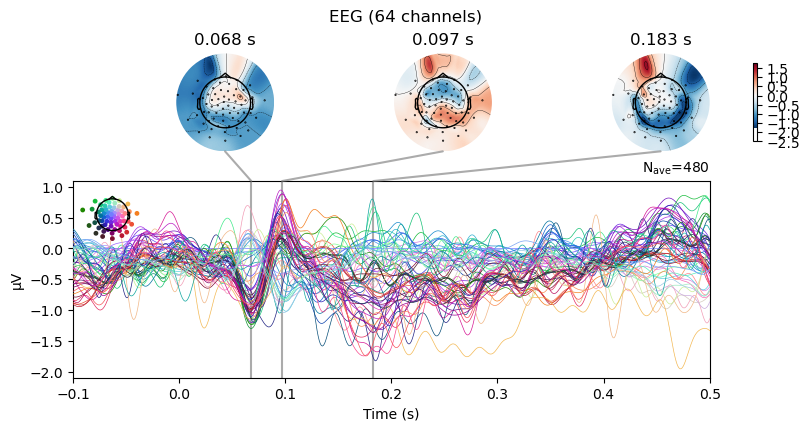

[<Figure size 800x420 with 6 Axes>, <Figure size 800x420 with 6 Axes>]

In [41]:
evoked_comparison = clean_epochs_comparison.average()
evoked_comparison.plot_joint()


No projector specified for this dataset. Please consider the method self.add_proj.


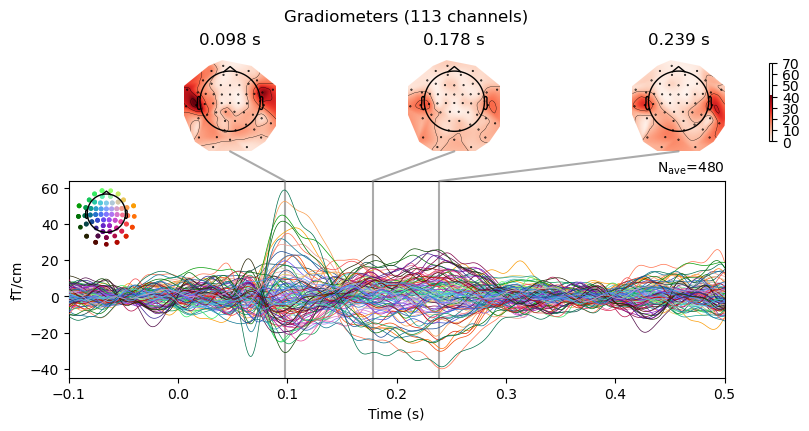

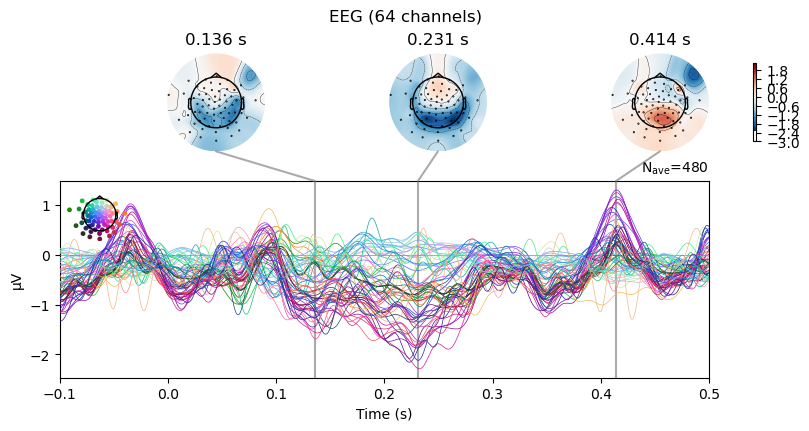

[<Figure size 800x420 with 6 Axes>, <Figure size 800x420 with 6 Axes>]

In [43]:
evoked_distraction = clean_epochs_distraction.average()
evoked_distraction.plot_joint()

Multiple channel types selected, returning one figure per type.
combining channels using RMS (grad channels)
combining channels using RMS (grad channels)


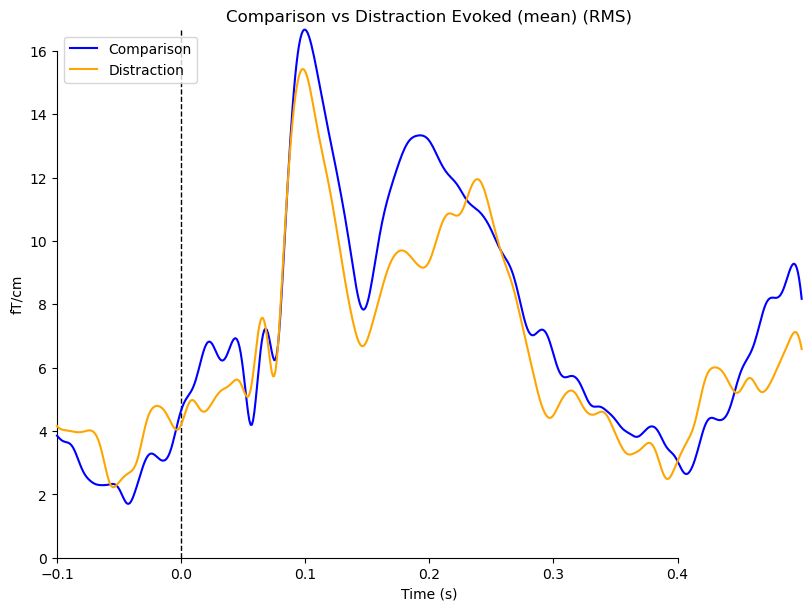

combining channels using GFP (eeg channels)
combining channels using GFP (eeg channels)


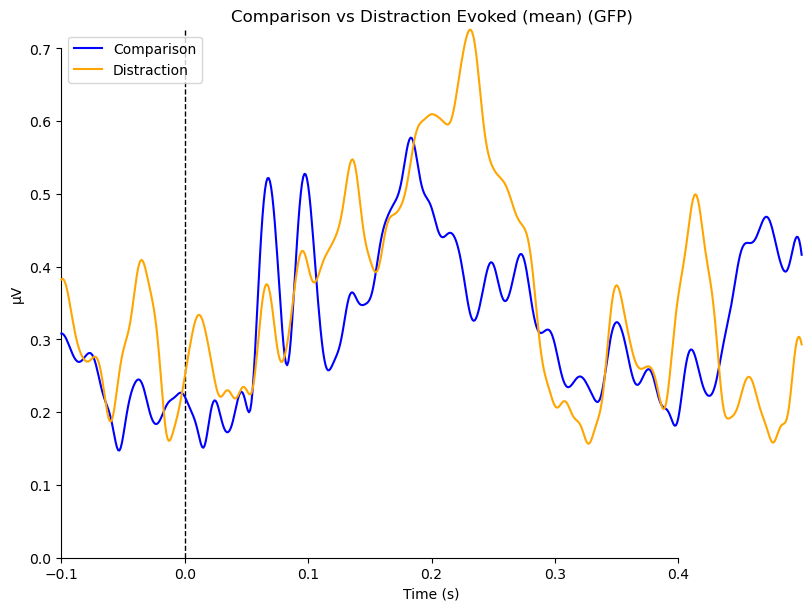

[<Figure size 800x600 with 1 Axes>, <Figure size 800x600 with 1 Axes>]

In [44]:
# Plot overlay of both evoked responses
mne.viz.plot_compare_evokeds({'Comparison': evoked_comparison,
                             'Distraction': evoked_distraction},
                            colors=['blue', 'orange'],
                            title='Comparison vs Distraction Evoked',
                            combine='mean')


    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).


C:\Users\pkhan\AppData\Local\Temp\ipykernel_12732\2263545675.py:1: UserWarning: Zero value in spectrum for channel Cz
  evoked_comparison.compute_psd().plot()
C:\Users\pkhan\AppData\Local\Temp\ipykernel_12732\2263545675.py:1: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  evoked_comparison.compute_psd().plot()
C:\Users\pkhan\AppData\Local\Temp\ipykernel_12732\2263545675.py:1: UserWarning: Infinite value in PSD for channel Cz.
These channels might be dead.
  evoked_comparison.compute_psd().plot()
c:\Users\pkhan\anaconda3\envs\mne\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


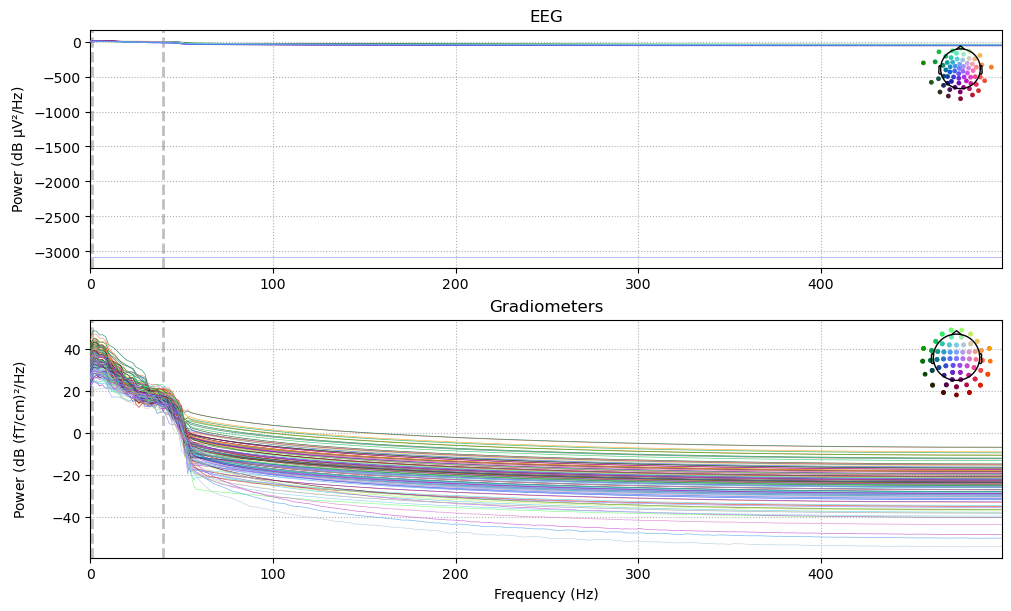

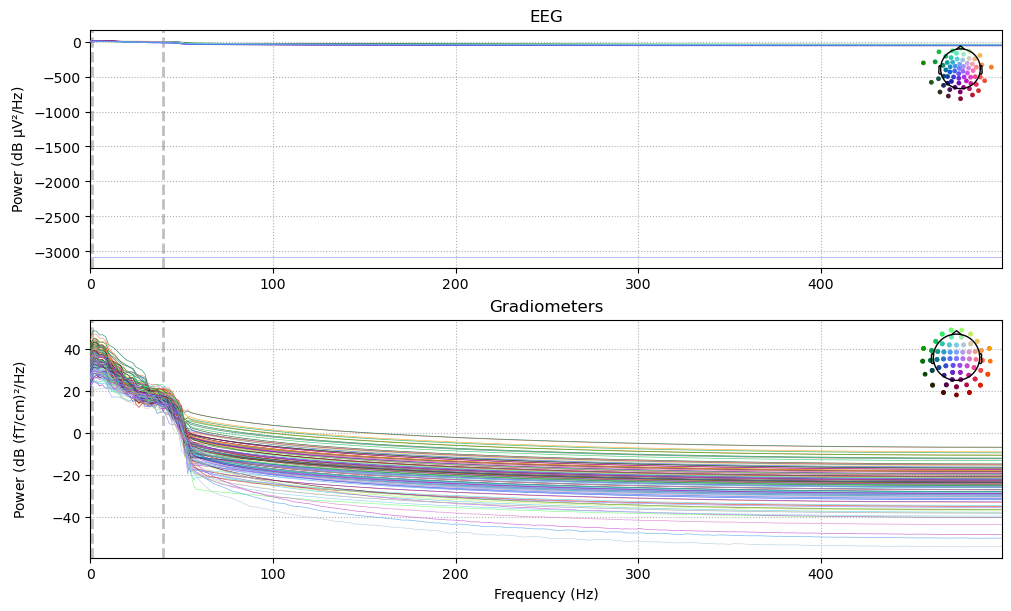

In [45]:
evoked_comparison.compute_psd().plot()

Saving the epochs and ERPs

In [46]:
epochs_dir = r"C:\Users\pkhan\Desktop\Kaiserslautern\Thesis\Data\Auditory_Epochs"
evokeds_dir = r"C:\Users\pkhan\Desktop\Kaiserslautern\Thesis\Data\Auditory_Evokeds"
# Save epochs and evokeds
clean_epochs_comparison.save(os.path.join(epochs_dir, 'a_epochs_comparison_4755.fif'), overwrite=True)
clean_epochs_distraction.save(os.path.join(epochs_dir, 'a_epochs_distraction_4755.fif'), overwrite=True)
evoked_comparison.save(os.path.join(evokeds_dir, 'a_evoked_comparison_4755.fif'), overwrite=True)
evoked_distraction.save(os.path.join(evokeds_dir, 'a_evoked_distraction_4755.fif'), overwrite=True)



C:\Users\pkhan\AppData\Local\Temp\ipykernel_12732\1288949132.py:4: RuntimeWarning: This filename (C:\Users\pkhan\Desktop\Kaiserslautern\Thesis\Data\Auditory_Epochs\a_epochs_comparison_4755.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  clean_epochs_comparison.save(os.path.join(epochs_dir, 'a_epochs_comparison_4755.fif'), overwrite=True)
C:\Users\pkhan\AppData\Local\Temp\ipykernel_12732\1288949132.py:5: RuntimeWarning: This filename (C:\Users\pkhan\Desktop\Kaiserslautern\Thesis\Data\Auditory_Epochs\a_epochs_distraction_4755.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  clean_epochs_distraction.save(os.path.join(epochs_dir, 'a_epochs_distraction_4755.fif'), overwrite=True)
C:\Users\pkhan\AppData\Local\Temp\ipykernel_12732\1288949132.py:6: RuntimeWarning: This filename (C:\Users\pkhan\Desktop\Kaiserslautern\Thesis\Data\Aud